In [1]:
!pip install -q tensorflow-datasets

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
print(type(imdb),type(info))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFITTGQ/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFITTGQ/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteFITTGQ/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
<class 'dict'> <class 'tensorflow_datasets.core.dataset_info.DatasetInfo'>


In [4]:
import numpy as np

train, test = imdb['train'], imdb['test']
print(type(train),type(test))
#basically a dataset iterable having (sentence,label) pair

<class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'> <class 'tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter'>


In [5]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [6]:
print(training_sentences[0])
print(training_labels[0])#0 for negative review and 1 for positive review
print(len(training_sentences))#training dataset size
print(len(testing_sentences))#testing dataset size

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0
25000
25000


In [14]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 64
MAX_LENGTH = 100
EPOCHS = 25
TRUNC_TYPE='post'
OOV_TOKEN = "<OOV>"

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOKEN)#Initializing Tokenizer
tokenizer.fit_on_texts(training_sentences)#creating vocabulary from training examples
word_index = tokenizer.word_index#get dictionary mapping like WORD==>NUMBER
sequences = tokenizer.texts_to_sequences(training_sentences)#making sequences from training sentences based on vocabulary
padded = pad_sequences(sequences,maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)#sequence padding is done

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)#fit testing corpus on existing vocabulary made on train datasset
testing_padded = pad_sequences(testing_sequences,maxlen=MAX_LENGTH)#pad testing corpus

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#function to generate sentence based on padded sequences in which ? is padded token,<OOV> for out of vocabulary token
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          49920     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                31104     
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
#Here we can see that model has overfitted on dataset
history=model.fit(padded, training_labels_final,
                  epochs=EPOCHS, 
                  validation_data=(testing_padded, testing_labels_final))

Epoch 1/25
782/782 [==============================] - 28s 36ms/step - loss: 0.4835 - accuracy: 0.7540 - val_loss: 0.3978 - val_accuracy: 0.8252
Epoch 2/25
782/782 [==============================] - 27s 35ms/step - loss: 0.3018 - accuracy: 0.8760 - val_loss: 0.3882 - val_accuracy: 0.8278
Epoch 3/25
782/782 [==============================] - 27s 35ms/step - loss: 0.2032 - accuracy: 0.9225 - val_loss: 0.4682 - val_accuracy: 0.8236
Epoch 4/25
782/782 [==============================] - 28s 35ms/step - loss: 0.1156 - accuracy: 0.9576 - val_loss: 0.5419 - val_accuracy: 0.8148
Epoch 5/25
782/782 [==============================] - 27s 34ms/step - loss: 0.0626 - accuracy: 0.9789 - val_loss: 0.7281 - val_accuracy: 0.8078
Epoch 6/25
782/782 [==============================] - 27s 35ms/step - loss: 0.0354 - accuracy: 0.9883 - val_loss: 0.9443 - val_accuracy: 0.7987
Epoch 7/25
782/782 [==============================] - 27s 35ms/step - loss: 0.0252 - accuracy: 0.9909 - val_loss: 0.9902 - val_accuracy:

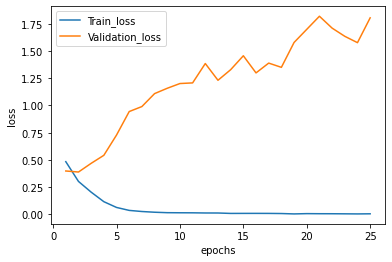

In [18]:
import matplotlib.pyplot as plt

epochs=len(history.history['loss'])
plt.plot([i for i in range(1,epochs+1)],history.history['loss'],label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],history.history['val_loss'],label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

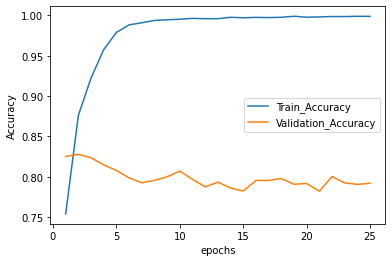

In [19]:
plt.plot([i for i in range(1,epochs+1)],history.history['accuracy'],label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],history.history['val_accuracy'],label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
del model

In [24]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 16
MAX_LENGTH = 100
EPOCHS = 25
TRUNC_TYPE='post'
OOV_TOKEN = "<OOV>"

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16,return_sequences=True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(8)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 32)           3264      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16)                2016      
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [26]:
#Here we can see that again this small model has overfitted on dataset
#This is because it has many OOV tokens in validation dataset
#so to avoid finely fit our moel on validation set we have to use pretrained embeddings
history=model.fit(padded, training_labels_final,
                  epochs=EPOCHS, 
                  validation_data=(testing_padded, testing_labels_final))

Epoch 1/25
782/782 [==============================] - 25s 33ms/step - loss: 0.5709 - accuracy: 0.7014 - val_loss: 0.4638 - val_accuracy: 0.8014
Epoch 2/25
782/782 [==============================] - 24s 31ms/step - loss: 0.3596 - accuracy: 0.8588 - val_loss: 0.4108 - val_accuracy: 0.8255
Epoch 3/25
782/782 [==============================] - 24s 31ms/step - loss: 0.2895 - accuracy: 0.8948 - val_loss: 0.4546 - val_accuracy: 0.8115
Epoch 4/25
782/782 [==============================] - 25s 32ms/step - loss: 0.2439 - accuracy: 0.9164 - val_loss: 0.4636 - val_accuracy: 0.8148
Epoch 5/25
782/782 [==============================] - 25s 32ms/step - loss: 0.2103 - accuracy: 0.9308 - val_loss: 0.4953 - val_accuracy: 0.8073
Epoch 6/25
782/782 [==============================] - 25s 31ms/step - loss: 0.1797 - accuracy: 0.9447 - val_loss: 0.5360 - val_accuracy: 0.8068
Epoch 7/25
782/782 [==============================] - 24s 31ms/step - loss: 0.1533 - accuracy: 0.9561 - val_loss: 0.5731 - val_accuracy:

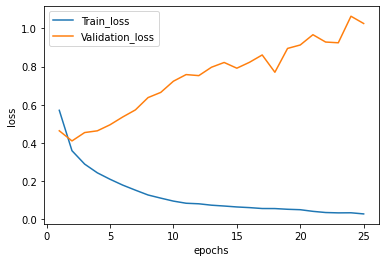

In [27]:
import matplotlib.pyplot as plt

epochs=len(history.history['loss'])
plt.plot([i for i in range(1,epochs+1)],history.history['loss'],label="Train_loss")
plt.plot([i for i in range(1,epochs+1)],history.history['val_loss'],label="Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

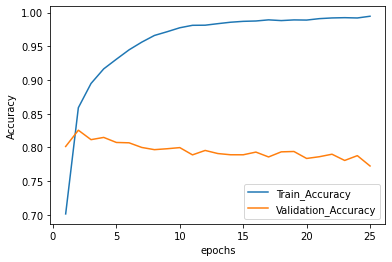

In [28]:
plt.plot([i for i in range(1,epochs+1)],history.history['accuracy'],label="Train_Accuracy")
plt.plot([i for i in range(1,epochs+1)],history.history['val_accuracy'],label="Validation_Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()